# Planning-Lab lesson 4: Reinforcement Learning

This tutorial will show some additional functionalities available to OpenAI Gym environments.

## Cliff Environment
The environment used is **Cliff** (taken from the book of Sutton and Barto, as visible in the figure)

![Cliff](images/cliff.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 11)$. Falling from the cliff resets the position to the start state (the episode ends only when the goal state is reached). All other cells are safe. Action dynamics is deterministic, meaning that the agent always reaches the desired next state.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

env = gym.make("Cliff-v0")
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



The cell types are the following:

- x - Start position
- o - Safe
- C - Cliff
- T - Goal

Rewards:

- -1 for each "safe" cell (o)
- -100 for falling from the cliff (C)

In addition to the functionalities of the environments you have been using in the previous sessions, there are also a few more:

- step(action): the agent performs action from the current state. Returns a tuple (new_state, reward, done, info) where:
    - new_state: is the new state reached as a consequence of the agent's last action
    - reward: the reward obtained by the agent
    - done: True if the episode has ended, False otherwise
    - info: not used, you can safely discard it

- reset(): the environment is reset and the agent goes back to the starting position. Returns the initial state id

In [2]:
state = env.reset()
action = 0 # Go UP
new_state, reward, done, _ = env.step(0)

print("State: {} \nAction: {} \nNew State: {} \nReward: {} \nDone: {}".format(state, action, new_state, reward, done))

State: 36 
Action: 0 
New State: 24 
Reward: -1 
Done: False


Suppose we want to execute a random policy in the environment: we create such policy as usual, we reset the environment to its initial state and also set a maximum number of steps for the episod. Then we execute a loop where at each iteration a step is performed by using the action defined by the policy.

In [22]:
policy = np.random.choice(env.action_space.n, env.observation_space.n)
print(policy)
state = env.reset()
ep_limit = 20

el = 0
total_reward = 0

# Episode execution loop
for _ in range(ep_limit):
    next_state, reward, done, _ = env.step(policy[state])  # Execute a step
    total_reward += reward
    el += 1
    if done or el == ep_limit:  # If done == True, the episode has ended
        break
    state = next_state
    
print("Reward of Random Policy:", total_reward)

[3 1 1 1 3 1 2 1 2 3 3 1 2 0 3 1 2 2 0 3 2 2 0 3 3 1 1 0 3 3 2 0 0 1 2 0 1
 0 3 3 0 3 3 3 2 3 0 2]
Reward of Random Policy: -2000


# Assignment 1:  Q-Learning
Your first assignment is to implement the Q-Learning algorithm on **Cliff**. In particular, you need to implement both $\epsilon$-greedy and Softmax versions for the exploration heuristic. The solution returned must be a tuple (policy, rewards, lengths) where:

- *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
- *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
- *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

Implemented exploration functions:
- *epsilon_greedy(q, state, epsilon)*
- *softmax(softmax(q, state, temp)*

**Functions to implement:**
- *q_learning(environment, episodes, alpha, gamma, expl_func, expl_param)*

It could be helpful to draw a number given specific probability distribution. In particular, among the 5 choices, the 3rd is the one that is most likely to be chosen (highest probability value)

In [21]:
np.random.choice(5, p=[0.1, 0.2, 0.5, 0.1, 0.1])

2

**The following exploration functions could be used in the algorithm:**

In [5]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    if np.random.random() < epsilon:
        return np.random.choice(q.shape[1])
    return q[state].argmax()

def softmax(q, state, temp):
    """
    Softmax action selection function
    
    Args:
    q: q table
    state: agent's current state
    temp: temperature parameter
    
    Returns:
        action id
    """
    e = np.exp(q[state] / temp)
    return np.random.choice(q.shape[1], p=e / e.sum())

**The following function has to be implemented:**

In [27]:
def q_learning(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon, T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    
    for episode in range(episodes):
        state = env.reset()
        while True:
            a = expl_func(q,state,expl_param)
            next_state, reward, done, _ = env.step(a)  # Execute a step
            rews[episode] += reward
            lengths[episode]+= 1
            val = [0 for _ in environment.actions]
            for action in environment.actions: 
                val[action]= q[next_state,action]
            q[state,a] = q[state,a] + alpha*(reward + gamma* max(val) - q[state,a])
            if done: 
                break
            state = next_state
    
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

**Notice that since the executions are stochastic, the policy could differ: the important thing is that the policy obtained using Q-Learning chooses the shortest path toward the goal.**

In [28]:
env_name = "Cliff-v0"
env = gym.make(env_name)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# Q-Learning epsilon greedy
policy, rewards, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print(f"Execution time: {round(timer() - t, 4)}s") 
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.shape))
_ = run_episode(env, policy, 20)

results = CheckResult_L4(policy_render)
results.check_qlearning()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


Execution time: 0.1753s

#####################################################
#######  Environment: Cliff-v0 	Q-Learning  #########
#####################################################

===> Your policy:

[['D' 'D' 'R' 'R' 'U' 'L' 'L' 'R' 'R' 'R' 'D' 'D']
 ['R' 'R' 'D' 'R' 'D' 'D' 'R' 'D' 'D' 'R' 'D' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]

===> Our policy:

[['D' 'U' 'D' 'R' 'D' 'R' 'D' 'D' 'L' 'D' 'D' 'D']
 ['D' 'U' 'R' 'R' 'R' 'U' 'D' 'R' 'D' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]


# Assignment 2: SARSA
Your second assignment is to implement the SARSA algorithm on **Cliff**. In particular, you need to implement both $\epsilon$-greedy and Softmax versions for the exploration heuristic (you can reuse the same functions of Assignment 1). The solution returned must be a tuple (policy, rewards, lengths) where:

- *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
- *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
- *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

**Functions to implement:**

- *SARSA(environment, episodes, alpha, gamma, expl_func, expl_param)*

In [29]:
def sarsa(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the SARSA algorithm for a specific environment
    
    Args:
        environment: OpenAI gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon, T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """

    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()
        a = expl_func(q,state,expl_param)
        while True:
            next_state, reward, done, _ = env.step(a)  # Execute a step
            a_1 = expl_func(q,next_state,expl_param)
            rews[episode] += reward
            lengths[episode]+= 1
            q[state,a] = q[state,a] + alpha*(reward + gamma*q[next_state,a_1]  - q[state,a])
            if done: 
                break
            state = next_state
            a = a_1

    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

**Notice that since the executions are stochastic, the policy could differ: the important thing is that the policy obtained using SARSA chooses the longer but safer path toward the goal.**

In [30]:
envname = "Cliff-v0"

env = gym.make(envname)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# SARSA epsilon greedy
policy, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print(f"Execution time: {round(timer() - t, 4)}s") 
_ = run_episode(env, policy, 20)
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.shape))


results = CheckResult_L4(policy_render)
results.check_sarsa()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


Execution time: 0.2208s

################################################
#######  Environment: Cliff-v0 	SARSA  #########
################################################

===> Your policy:

[['R' 'R' 'R' 'R' 'R' 'R' 'D' 'R' 'R' 'R' 'R' 'D']
 ['U' 'R' 'R' 'D' 'U' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'R' 'U' 'U' 'U' 'U' 'U' 'U' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]

===> Our policy:

[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'D']
 ['U' 'U' 'U' 'U' 'R' 'U' 'U' 'R' 'R' 'U' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'L' 'U' 'R' 'R' 'U' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]


## Discussion
Now that you have veryfied the results, try to employ Softmax instead of $\epsilon$-greedy as exploration heuristic. Are there any significant changes? Why?

# Comparison

The following code performs a comparison between the 2 reinforcement learning algorithms: *Q-Learning* and *SARSA*. Execute the following code and analyze the charts:


###########################################################
################ Environment: Cliff-v0 ####################
###########################################################

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Execution time: 0.3784s


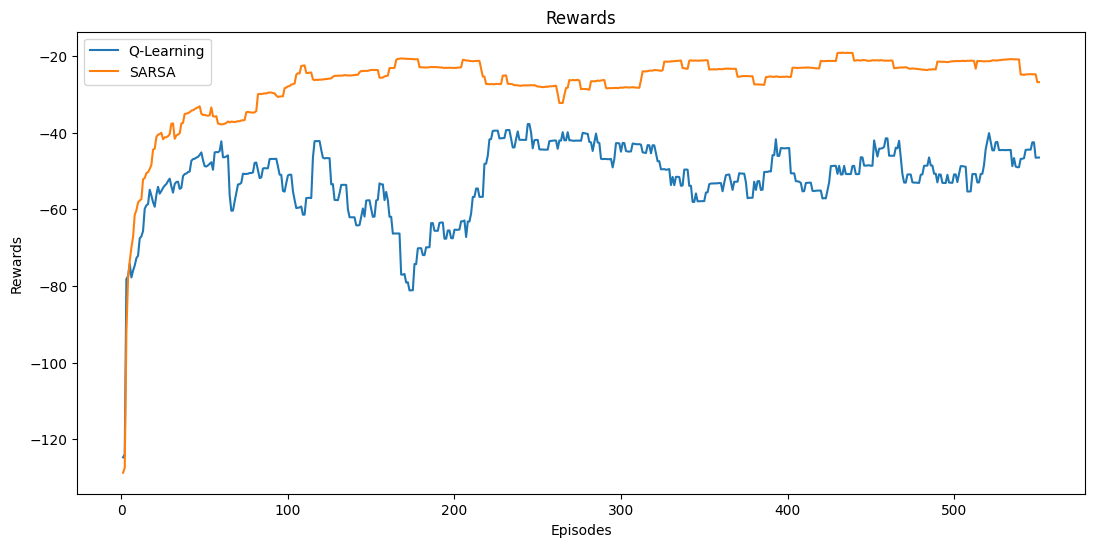

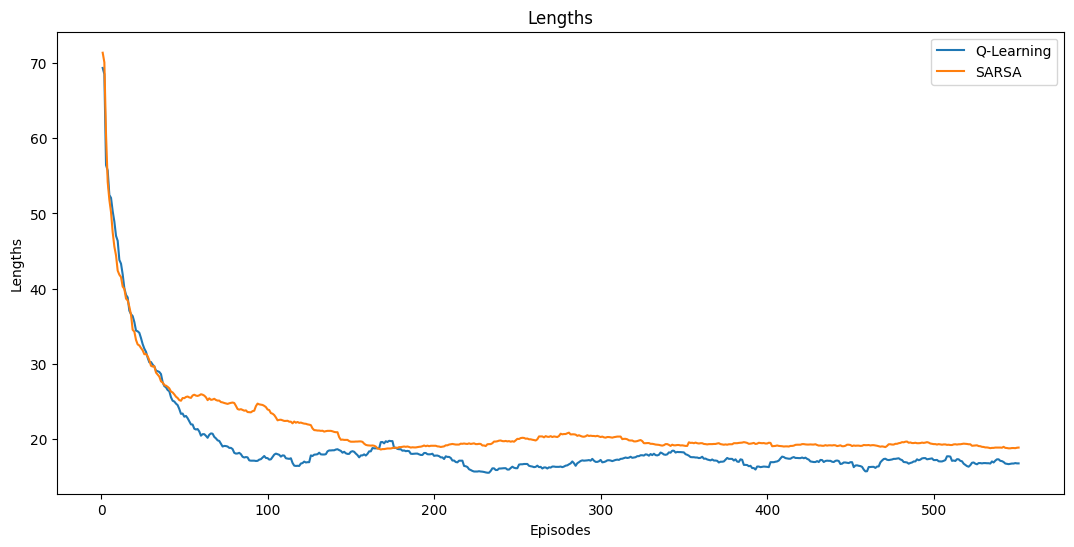

In [31]:
envname = "Cliff-v0"
print()
print("###########################################################")
print("################ Environment: Cliff-v0 ####################")
print("###########################################################\n")

env = gym.make(envname)
env.render()

# Learning parameters
episodes = 600
ep_limit = 50
vmaxiters = 50
alpha = .3
gamma = .9
epsilon = .1
delta = 1e-3

rewser = []
lenser = []

litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 50  # Rolling window
mrew = np.zeros(episodes)
mlen = np.zeros(episodes)

t = timer()

# Q-Learning
_, rews, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})

# SARSA
_, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "SARSA"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "SARSA"})

print("Execution time: {0}s".format(round(timer() - t, 4)))

plot(rewser, "Rewards", "Episodes", "Rewards")
plot(lenser, "Lengths", "Episodes", "Lengths")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend.

**Algorithms Reward comparison**
<img src="images/results-reward.png" width="600">

**Algorithms Episode Length comparison**
<img src="images/results-length.png" width="600">